In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import desc
from sqlalchemy import func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
Session = Session(engine)

# Exploratory Climate Analysis

2017-08-23
2016-08-23
Date range is starting from 2016-08-23 and ending at 2017-08-23


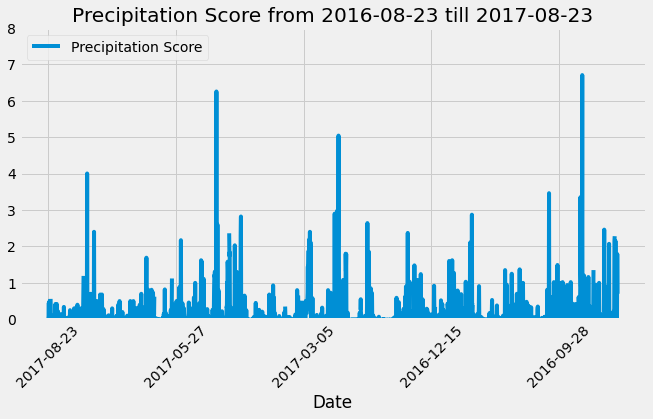

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
Latest_date = Session.execute("SELECT MAX(date) FROM Measurement").fetchall()

Latest_date = Session.query(func.max(Measurement.date)).all()

End_date = Latest_date[0][0]

print(End_date)

# Calculate the date 1 year ago from the last data point in the database
Struct = dt.date.today()

End_date_dateformat = Struct.replace(year=int(End_date[:4]), month=int(End_date[5:7]),day=int(End_date[8:]))

Last_date_year = End_date_dateformat - dt.timedelta(days=365)

Start_Date = Last_date_year.strftime("%Y-%m-%d")

print(Start_Date)

print("Date range is starting from {} and ending at {}".format (Start_Date, End_date))

# Perform a query to retrieve the data and precipitation scores
PRCP_data = Session.query(Measurement.date,Measurement.prcp)\
                            .filter(Measurement.date <= End_date)\
                            .filter(Measurement.date >= Start_Date)\
                            .order_by(Measurement.date.desc()).all()


# Save the query results as a Pandas DataFrame and set the index to the date column
PRCP_data_DF = pd.DataFrame(PRCP_data).rename(columns={"date":"Date","prcp":"Precipitation Score"})
PRCP_data_DF.set_index("Date", inplace=True)
PRCP_data_DF.head()
# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data
PRCP_data_DF.plot(figsize=(10,5),ylim=(0,8),title=f'Precipitation Score from {Start_Date} till {End_date}',\
                  label= "Precipitation",rot=45)
plt.legend(loc='upper left')
plt.savefig("Resources/1_Precipitation_Analysis.jpg")
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
PRCP_data_DF.describe()

,Precipitation Score
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
Total_stations = Session.execute("Select count(*) from Station").fetchall()
print(f'Total number of stations is: {Total_stations[0][0]}')

Total number of stations is: 9


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
Most_Active_stations = Session.execute("Select station as Station_id,count(station)\
                                        as Num_of_Obs from Measurement\
                                        group by station order by 2 desc")\
                                        .fetchall()

for all in Most_Active_stations:
    print(all)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [15]:
print("Rank\tstation ID\tObservations")
i = 1 
for Active_stations in Most_Active_stations:
    print("%d\t%s\t%d" %(i, Active_stations[0], Active_stations[1]))
    i+=1

Rank	station ID	Observations
1	USC00519281	2772
2	USC00519397	2724
3	USC00513117	2709
4	USC00519523	2669
5	USC00516128	2612
6	USC00514830	2202
7	USC00511918	1979
8	USC00517948	1372
9	USC00518838	511


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
Station_Highest_Obs = Session.query(Measurement.station, func.count(Measurement.station))\
                    .group_by(Measurement.station)\
                    .order_by(desc(func.count(Measurement.station))).first()

print("The most active station is the one with the highest number of observations, which is "+str(Station_Highest_Obs[0])+" with " +\
        str(Station_Highest_Obs[1]) + " number of observations.")


The most active station is the one with the highest number of observations, which is USC00519281 with 2772 number of observations.


In [17]:
Session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs))\
                .filter(Measurement.station == Station_Highest_Obs[0]).all()

[(54.0, 85.0, 71.66378066378067)]

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
Results = Session.query(Measurement.date,Measurement.station,Measurement.tobs)\
            .filter(Measurement.date >= Start_Date). filter(Measurement.date<=End_date)\
            .filter(Measurement.station == Station_Highest_Obs[0]).order_by(desc(Measurement.date)).all()

In [19]:
Last12_tobs_DF = pd.DataFrame(Results,columns=["Date", "Station ID", "Temperature_Recorded"])
Last12_tobs_DF.head()

,Date,Station ID,Temperature_Recorded
0,2017-08-18,USC00519281,79.0
1,2017-08-17,USC00519281,76.0
2,2017-08-16,USC00519281,76.0
3,2017-08-15,USC00519281,77.0
4,2017-08-14,USC00519281,77.0


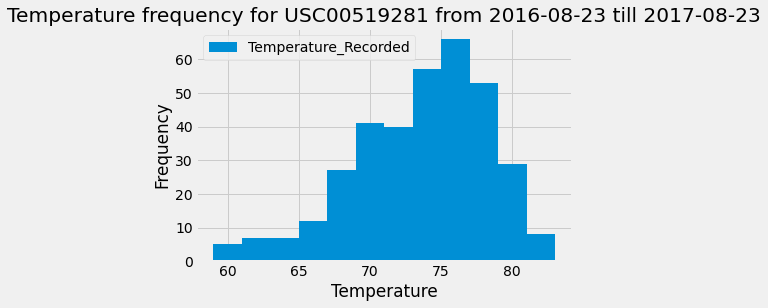

In [20]:
Last12_tobs_DF.plot.hist(by="Tobs",bins=12, label="tobs",title=f'Temperature frequency for {Station_Highest_Obs[0]} from {Start_Date} till {End_date}')
plt.ylim=(0,80)
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.legend=()
plt.savefig("Resources/2_Temperature_Analysis.jpg")
plt.show()

## Bonus Challenge Assignment

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(Start_Date, End_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return Session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= Start_Date).filter(Measurement.date <= End_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
Trip_start_date = input("Enter the trip start date in 'YYYY-MM-DD' format: ")
Trip_end_date = input("Enter the trip end date in 'YYYY-MM-DD' format: ")

Enter the trip start date in 'YYYY-MM-DD' format: 2018-07-04
Enter the trip end date in 'YYYY-MM-DD' format: 2018-07-15


In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
Struct = dt.date.today()
Trip_start_date_dateformat = Struct.replace(year=int(Trip_start_date[:4]),month=int(Trip_start_date[5:7]),day=int(Trip_start_date[8:]))
Previous_Trip_start_date = Trip_start_date_dateformat - dt.timedelta(days=365)
Previous_Trip_start_date = Previous_Trip_start_date.strftime("%Y-%m-%d")
Previous_Trip_start_date
Trip_end_date_dateformat = Struct.replace(year=int(Trip_end_date[:4]),month=int(Trip_end_date[5:7]),day=int(Trip_end_date[8:]))
Previous_Trip_end_date = Trip_end_date_dateformat - dt.timedelta(days=365)
Previous_Trip_end_date = Previous_Trip_end_date.strftime("%Y-%m-%d")
Previous_Trip_end_date

'2017-07-15'

In [26]:
Result = calc_temps(Previous_Trip_start_date, Previous_Trip_end_date)
print(Result)

[(69.0, 78.11842105263158, 82.0)]


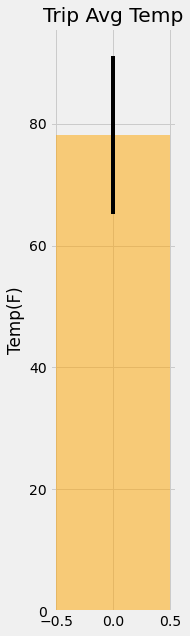

In [37]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

tmin = Result[0][0]
tavg = Result[0][1]
tmax = Result [0][2]
y_err = tmax-tmin

plt.figure(figsize=(2,10))
plt.bar(0,tavg, yerr=y_err, align="center", width=1, color="orange", alpha=0.5)
plt.ylim=(0,120)
plt.ylabel("Temp(F)")
plt.title ("Trip Avg Temp")
plt.savefig("Resources/3_Trip_Avg_Temp_Analysis")
plt.show()

In [38]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.

Results = Session.query(Measurement.station, func.sum(Measurement.prcp))\
                       .filter(Measurement.date>=Previous_Trip_start_date).filter(Measurement.date<=Previous_Trip_end_date)\
                       .group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()  
print("Station Id\tTotal Rainfall")
for each in Results: print(each[0],"\t",each[1])  


Station Id	Total Rainfall
USC00516128 	 1.87
USC00519281 	 1.26
USC00513117 	 0.5900000000000001
USC00514830 	 0.39
USC00519397 	 0.13
USC00519523 	 0.11
USC00517948 	 None


In [39]:
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel = [Measurement.station,Station.name,func.sum(Measurement.prcp),Station.latitude,Station.longitude,Station.elevation]
Results = Session.query(*sel).filter(Measurement.station==Station.station)\
                       .filter(Measurement.date>=Previous_Trip_start_date).filter(Measurement.date<=Previous_Trip_end_date)\
                       .group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()

for result in Results: print(result)

('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 1.87, 21.3331, -157.8025, 152.4)
('USC00519281', 'WAIHEE 837.5, HI US', 1.26, 21.45167, -157.84888999999998, 32.9)
('USC00513117', 'KANEOHE 838.1, HI US', 0.5900000000000001, 21.4234, -157.8015, 14.6)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 0.39, 21.5213, -157.8374, 7.0)
('USC00519397', 'WAIKIKI 717.2, HI US', 0.13, 21.2716, -157.8168, 3.0)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 0.11, 21.33556, -157.71139, 19.5)
('USC00517948', 'PEARL CITY, HI US', None, 21.3934, -157.9751, 11.9)


In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
